In [427]:
import warnings
warnings.filterwarnings('ignore')

### Импорт библиотек

In [428]:
# Импорт библиотек для проведения расчетов
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import mean_squared_error

In [429]:
# Импорт библиотек для визуализации
from matplotlib import pyplot as plt
import seaborn as sns

In [430]:
# Импорт библиотеки кластеризации переменных
# https://pypi.org/project/varclushi/
from varclushi import VarClusHi

## Загрузка данных

In [431]:
# Указываем путь к файлу
# При работе с google colab существует 2 варианта загрузки файла:
# 1. Через google drive
# 2. Через левое меню: "файлы" -> "загрузить в сессионное хранилище" -> "скопировать файл" (при наведении на файл)
file_path = 'white_wine.csv'

In [432]:
# Загружаем данные из SAS файла
df = pd.read_csv(file_path)
df = df.astype('float')
df = df.rename(columns=lambda x: x.strip())
# Пример данных
df.head()

,fixed acidity,volatile acidity,citric acid,sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,target_quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6.0
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6.0
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6.0
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6.0
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6.0


## Функции обработки

In [433]:
# Метод главных компонент
def pca_transform(X, transform = []):
    pca_model = PCA(n_components='mle')
    pca_model.fit(X)

    if transform == []:
        transform = [X]
    return [pca_model.transform(t) for t in transform]

In [434]:
# Кластеризация переменных
def variable_clustering(X, transform = []):
    var_clust_model = VarClusHi(X, maxeigval2 = .7, maxclus = None)
    var_clust_model.varclus()
    var_clust = var_clust_model.rsquare.loc[:, ["Cluster","Variable","RS_Ratio"]]
    vars = var_clust.sort_values("RS_Ratio").drop_duplicates(['Cluster'],keep='first')["Variable"].to_list()

    if transform == []:
        transform = [X]
    return [t.loc[:, vars] for t in transform]

In [435]:
# Разделение на обучающую, валидационную и тестовую выборку
def data_partition(X, y):
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, stratify = y, test_size=0.6, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_test_val, y_test_val, stratify = y_test_val, test_size=0.5, random_state=42)
    return (X_train, y_train, X_val, y_val, X_test, y_test)

In [436]:
# Расчет ошибки прогнозирования
def score_model_mae(model, 
                    X_train, y_train,
                    X_val, y_val,
                    X_test, y_test):
    print(model.__class__.__name__)
    print("TRAIN MSE: {:f}".format(mean_squared_error(y_train, model.predict(X_train))))
    print("VAL MSE: {:f}".format(mean_squared_error(y_val, model.predict(X_val))))
    print("TEST MSE: {:f}".format(mean_squared_error(y_test, model.predict(X_test))))

## Формирование признакового пространства

In [437]:
df.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'target_quality'],
      dtype='object')

In [438]:
# Сформируем признаковое пространство:
# Целевая переменная: target_quality. Описывает субъективную оценку качества сорта вина. 
# Остальные переменные - входные. 
# Задача – спрогнозировать оценку эксперта в зависимости от объективных химических показателей вина и выявить важные признаки
y = df["target_quality"].to_frame()
X = df.loc[:, list(set(df.columns) - {"target_quality"})]

# Дискретизация отклика
qtransform = QuantileTransformer(output_distribution='normal', n_quantiles = 5, random_state = 42)
y.values[:] = qtransform.fit_transform(y)

## Часть 1: KNN

In [439]:
from sklearn.neighbors import KNeighborsRegressor

X_train, y_train, X_val, y_val, X_test, y_test = data_partition(X, y)

# Стандартизация
scaler = StandardScaler()
scaler.fit(X_train)
for X_ in (X_train, X_val, X_test):
    X_.values[:] = scaler.transform(X_)

# KNN 
knn = KNeighborsRegressor(n_neighbors=20)
knn.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=20)

### Вопросы части 1:

1. Какие значения MSE получились на тренировочном, валидационном и тестовом наборе данных?
2. Перед применением KNN вставьте предобработку PCA (Вариант I), Variable clustering (Вариант II). 
3. Сколько переменных теперь передается на вход KNN? Как изменились значения MSE в результате? Почему это могло произойти?

### Вопрос 1

In [440]:
# MSE
score_model_mae(knn, X_train, y_train, X_val, y_val, X_test, y_test)

KNeighborsRegressor
TRAIN MSE: 0.385404
VAL MSE: 0.441951
TEST MSE: 0.402548


### Вопрос 2

In [441]:
# Применяем кластеризацию переменных
X_clustered = variable_clustering(X)[0]
X_train, y_train, X_val, y_val, X_test, y_test = data_partition(X_clustered, y)

# Стандартизация
scaler = StandardScaler()
scaler.fit(X_train)
for X_ in (X_train, X_val, X_test):
    X_.values[:] = scaler.transform(X_)

# KNN
knn = KNeighborsRegressor(n_neighbors=20)
knn.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=20)

### Вопрос 3

In [442]:
# Сколько переменных передается в knn

X_train.shape[1]

7

In [443]:
# Как изменилось значение MSE

score_model_mae(knn, X_train, y_train, X_val, y_val, X_test, y_test)

KNeighborsRegressor
TRAIN MSE: 0.413794
VAL MSE: 0.450412
TEST MSE: 0.432806


MSE Повысился из-за того, что убранные переменные были важны для knn

## Часть 2: Regression

In [444]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SequentialFeatureSelector
import statsmodels.api as sm
# Документация для OLS
# https://bookdown.org/mike/data_analysis/ordinary-least-squares.html

X_train, y_train, X_val, y_val, X_test, y_test = data_partition(X, y)

# MinMax стандартизация (вставьте свой код)

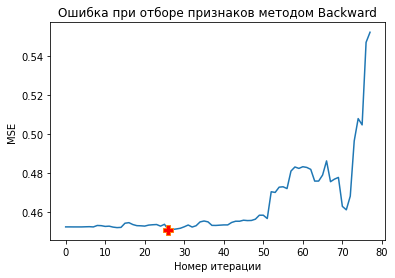

LinearRegression
TRAIN MSE: 0.374462
VAL MSE: 0.450904
TEST MSE: 0.390574


In [445]:
# Построим полиномиальную регрессию (degree = 2)

# Отобразмим пространство признаков в пространство полиномов степени 2
poly_reg = PolynomialFeatures(degree=2)
X_train = poly_reg.fit_transform(X_train)
X_val = poly_reg.transform(X_val)
X_test = poly_reg.transform(X_test)

# Определим лучшее число признаков с помощью Backward (измените код для отбора с помощью Forward)
best_feats = None
features = list(range(X_train.shape[1]))
errs = []
while len(features) > 0:
    lr = LinearRegression()
    lr.fit(X_train[:, features], y_train)
    err = mean_squared_error(y_val, lr.predict(X_val[:, features]))
    errs.append(err)
    if min(errs) == err:
        best_feats = features.copy()

    model = sm.OLS(y_train, X_train[:, features])
    res = model.fit()

    # Выбираем худший признак и удаляем из пространства признаков
    worse_feature = features[np.argmax(res.pvalues)]
    features.remove(worse_feature)

# Визуализируем ошибки
idx = len(errs) - len(best_feats)
plt.plot(errs)
plt.plot(idx, errs[idx], 'P', ms=10, mfc='red')
plt.xlabel("Номер итерации")
plt.ylabel("MSE")
plt.title("Ошибка при отборе признаков методом Backward")
plt.show()

# Обучим линейную регрессию на лучших признаках
lr = LinearRegression()
lr.fit(X_train[:, best_feats], y_train)

score_model_mae(lr, 
                X_train[:, best_feats], y_train, 
                X_val[:, best_feats], y_val, 
                X_test[:, best_feats], y_test)

### Вопросы к части 2:

1. Аналогично алгоритму выбора признаков Backward, опишите алгоритм Forward
2. Какая модель показывает лучшее качество на тестовом наборе? 
3. Какие переменные не вошли в результирующую регрессионую модель? 
4. На каком шаге была выбрана лучшая модель?
5. С помощью summary() определите какая из вошедших переменных наименее важная с точки зрения t-статистики?

5. После разделения данных добавьте MinMaxScaler. Как изменились результаты регрессионной модели с точки числа степеней свободы и значения MSE на тестовом наборе?

### Вопрос 1

In [446]:
def get_model_err(features, X_train, y_train, X_val, y_val):
    lr = LinearRegression()
    lr.fit(X_train[:, features], y_train)
    err = mean_squared_error(y_val, lr.predict(X_val[:, features]))
    return err

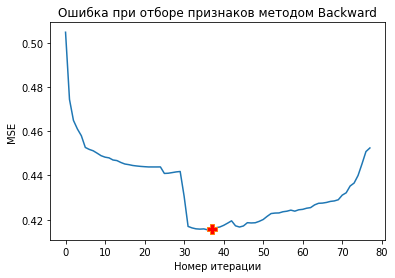

LinearRegression
TRAIN MSE: 0.415995
VAL MSE: 0.415390
TEST MSE: 0.405762


In [447]:
X_train, y_train, X_val, y_val, X_test, y_test = data_partition(X, y)

# Построим полиномиальную регрессию (degree = 2)
# Отобразмим пространство признаков в пространство полиномов степени 2
poly_reg = PolynomialFeatures(degree=2)
X_train = poly_reg.fit_transform(X_train)
X_val = poly_reg.transform(X_val)
X_test = poly_reg.transform(X_test)

# Forward feature selection
best_feats = None
remaining_feats = list(range(X_train.shape[1]))
selected_features = []
errs = []
best_err = 1
while len(selected_features) < X_train.shape[1]:

    current_best_err = 1
    current_best_features = []
    selected_feature = None

    for feature in remaining_feats:
        tmp_feats = [feature, *selected_features]
        err = get_model_err(tmp_feats, X_train, y_train, X_val, y_val)
        if err < current_best_err:
            selected_feature = feature
            current_best_err = err
            current_best_features = tmp_feats

    errs.append(current_best_err)

    if current_best_err < best_err:
        best_err = current_best_err
        best_feats = current_best_features

    remaining_feats.remove(selected_feature)
    selected_features.append(selected_feature)

# Визуализируем ошибки
idx = len(best_feats)
plt.plot(errs)
plt.plot(idx, errs[idx], 'P', ms=10, mfc='red')
plt.xlabel("Номер итерации")
plt.ylabel("MSE")
plt.title("Ошибка при отборе признаков методом Backward")
plt.show()

# Обучим линейную регрессию на лучших признаках
lr = LinearRegression()
lr.fit(X_train[:, best_feats], y_train)

score_model_mae(lr,
                X_train[:, best_feats], y_train,
                X_val[:, best_feats], y_val,
                X_test[:, best_feats], y_test)

### Вопрос 2

Backward оказался лучше на тестовом MSA = 0.390, а у Forward MSE = 0.405

### Вопрос 3

Не попавшие в выборку переменные

In [448]:
pd.DataFrame([poly_reg.get_feature_names_out()[i] for i in set(range(X_train.shape[1])) - set(best_feats)])

,0
0,fixed acidity
1,pH
2,chlorides
3,total sulfur dioxide
4,sulphates
5,free sulfur dioxide
6,sugar^2
7,sugar density
8,density^2
9,density fixed acidity


### Вопрос 4

Лучшая модель была выбрана на шаге равном длине переменных, которые вошли в лучшую выборку

In [449]:
len(best_feats) + 1

38

### Вопрос 5

In [450]:
model = sm.OLS(y_train, X_train[:, best_feats]).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         target_quality   R-squared:                       0.291
Model:                            OLS   Adj. R-squared:                  0.278
Method:                 Least Squares   F-statistic:                     21.94
Date:                Fri, 22 Apr 2022   Prob (F-statistic):          2.85e-117
Time:                        16:44:11   Log-Likelihood:                -1920.6
No. Observations:                1959   AIC:                             3915.
Df Residuals:                    1922   BIC:                             4122.
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1           268.1371    146.453      1.831      0.067     -19.086     555.361
x2            -0.0024      0.025     -0.095      0.925      -0.051       0.046
x3            -6.4306      1.609     -3.997      0.000      -9.586      -3.276
x4             0.3378      0.103      3.268      0.001       0.135       0.540
x5             0.4942      0.137      3.620      0.000       0.226       0.762
x6             1.0706      0.262      4.083      0.000       0.556       1.585
x7           -98.2608    194.048     -0.506      0.613    -478.828     282.307
x8            -0.0726      1.288     -0.056      0.955      -2.598       2.453
x9             0.0285      0.030      0.942      0.347      -0.031       0.088
x10            0.0289      0.013      2.289      0.022       0.004       0.054
x11           -9.9591     17.700     -0.563      0.574     -44.672      24.754
x12           -0.0461      0.033     -1.390      0.165      -0.111       0.019
x13           13.5902     12.201      1.114      0.265     -10.339      37.519
x14          -12.6728      5.640     -2.247      0.025     -23.733      -1.612
x15           -1.0744      0.390     -2.758      0.006      -1.838      -0.310
x16            0.4854      0.201      2.413      0.016       0.091       0.880
x17           -0.2486      1.210     -0.206      0.837      -2.621       2.124
x18           -0.0601      0.020     -2.947      0.003      -0.100      -0.020
x19           10.2767      4.807      2.138      0.033       0.850      19.703
x20           -0.8358      1.124     -0.743      0.457      -3.041       1.369
x21           -0.0006      0.007     -0.078      0.938      -0.015       0.014
x22           -0.2536      0.083     -3.064      0.002      -0.416      -0.091
x23         -270.9407    146.642     -1.848      0.065    -558.535      16.654
x24            9.8900     17.983      0.550      0.582     -25.378      45.158
const         96.5999    194.620      0.496      0.620    -285.089     478.289
x25            0.0061      0.003      2.008      0.045       0.000       0.012
x26        -1.585e-05   6.09e-06     -2.602      0.009   -2.78e-05    -3.9e-06
x27           -0.0052      0.004     -1.172      0.241      -0.014       0.004
x28            0.0869      0.203      0.429      0.668      -0.310       0.484
x29           -0.0006      0.000     -2.298      0.022      -0.001   -8.14e-05
x30            0.0209      0.008      2.717      0.007       0.006       0.036
x31           -0.0002   3.31e-05     -4.565      0.000      -0.000   -8.63e-05
x32            0.0054      0.002      3.353      0.001       0.002       0.009
x33           -0.0029      0.010     -0.285      0.776      -0.023       0.017
x34         6.746e-05      0.000      0.596      0.551      -0.000       0.000
x35           -0.0243      0.036     -0.669      0.503      -0.096       0.047
x3

In [451]:
i = np.argmin(np.abs(model.tvalues))
poly_reg.get_feature_names_out()[best_feats[i]]

'volatile acidity sulphates'

### Вопрос 6

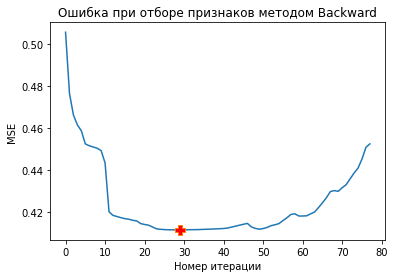

LinearRegression
TRAIN MSE: 0.420403
VAL MSE: 0.411562
TEST MSE: 0.417528


In [452]:
X_train, y_train, X_val, y_val, X_test, y_test = data_partition(X, y)

scaler = MinMaxScaler()
scaler.fit(X_train)
for X_ in (X_train, X_val, X_test):
    X_.values[:] = scaler.transform(X_)

# Построим полиномиальную регрессию (degree = 2)
# Отобразмим пространство признаков в пространство полиномов степени 2
poly_reg = PolynomialFeatures(degree=2)
X_train = poly_reg.fit_transform(X_train)
X_val = poly_reg.transform(X_val)
X_test = poly_reg.transform(X_test)

# Forward feature selection
best_feats = None
remaining_feats = list(range(X_train.shape[1]))
selected_features = []
errs = []
best_err = 1
while len(selected_features) < X_train.shape[1]:

    current_best_err = 1
    current_best_features = []
    selected_feature = None

    for feature in remaining_feats:
        tmp_feats = [feature, *selected_features]
        err = get_model_err(tmp_feats, X_train, y_train, X_val, y_val)
        if err < current_best_err:
            selected_feature = feature
            current_best_err = err
            current_best_features = tmp_feats

    errs.append(current_best_err)

    if current_best_err < best_err:
        best_err = current_best_err
        best_feats = current_best_features

    remaining_feats.remove(selected_feature)
    selected_features.append(selected_feature)

# Визуализируем ошибки
idx = len(best_feats)
plt.plot(errs)
plt.plot(idx, errs[idx], 'P', ms=10, mfc='red')
plt.xlabel("Номер итерации")
plt.ylabel("MSE")
plt.title("Ошибка при отборе признаков методом Backward")
plt.show()

# Обучим линейную регрессию на лучших признаках
lr = LinearRegression()
lr.fit(X_train[:, best_feats], y_train)

score_model_mae(lr,
                X_train[:, best_feats], y_train,
                X_val[:, best_feats], y_val,
                X_test[:, best_feats], y_test)

In [453]:
print(f" Всего выбрано {len(best_feats)} переменных")

 Всего выбрано 29 переменных


## Часть 3: PLS/PCR

In [454]:
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict

X_train, y_train, X_val, y_val, X_test, y_test = data_partition(X, y)

# Метод PCR представляем в виде комбинации PCA с последующей линейной регрессией
pcr = make_pipeline(PCA(n_components=5), LinearRegression())
pcr.fit(X_train, y_train)

pls = PLSRegression(n_components=5)
pls.fit(X_train, y_train)

# MSE
score_model_mae(pcr, X_train, y_train, X_val, y_val, X_test, y_test)
score_model_mae(pls, X_train, y_train, X_val, y_val, X_test, y_test)

Pipeline
TRAIN MSE: 0.477364
VAL MSE: 0.496493
TEST MSE: 0.471302
PLSRegression
TRAIN MSE: 0.441024
VAL MSE: 0.464150
TEST MSE: 0.445547


In [455]:
# Необходимо определить лучшее количество компонент

def optimise_comp_cv(X, y, n_comp, model_name):
    if model_name == "PCR":
        model = make_pipeline(PCA(n_components=n_comp), LinearRegression())
    else:
        model = PLSRegression(n_components=n_comp)

    # Расчет ошибки на кросс-валидации
    y_cv = cross_val_predict(model, X, y, cv=10)
    mse = mean_squared_error(y, y_cv)
    return mse

# Визуализация MSE
def plot_metrics(vals, ylabel, objective, xticks, model_name):
    plt.plot(xticks, np.array(vals), '-v')
    if objective=='min':
        idx = np.argmin(vals)
    else:
        idx = np.argmax(vals)
    plt.plot(xticks[idx], np.array(vals)[idx], 'P', ms=10, mfc='red')

    plt.xlabel(f'Количество компонент {model_name}')
    plt.xticks = xticks
    plt.ylabel(ylabel)
    plt.title(model_name)
    plt.show()


### Вопросы к части 3:

1. Сколько компонент было выбрано для моделей PCR и PLS?
2. Какое значение MSE модели показывают на тестовом наборе?

### Вопрос 1

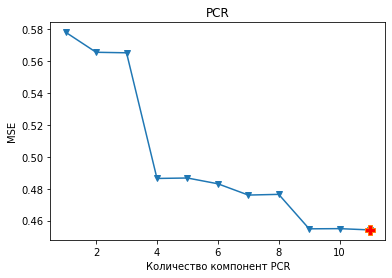

In [456]:
# PCR
model_name = "PCR"
X_tr_val = pd.concat([X_train, X_val])
y_tr_val = pd.concat([y_train, y_val])
mses = []
list_components = list(range(1, X_tr_val.shape[1]+1))
for n_comp in list_components:
    mse = optimise_comp_cv(X_tr_val, y_tr_val, n_comp, model_name)
    mses.append(mse)
plot_metrics(mses, 'MSE', 'min', list_components, model_name)

у PCR было выбрано 11 компонент

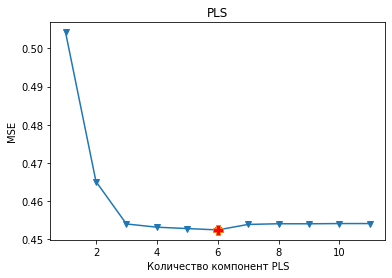

In [457]:
# PCR
model_name = "PLS"
X_tr_val = pd.concat([X_train, X_val])
y_tr_val = pd.concat([y_train, y_val])
mses = []
list_components = list(range(1, X_tr_val.shape[1]+1))
for n_comp in list_components:
    mse = optimise_comp_cv(X_tr_val, y_tr_val, n_comp, model_name)
    mses.append(mse)
plot_metrics(mses, 'MSE', 'min', list_components, model_name)

у PLS Было выбрано 6 компонент

### Вопрос 2

MSE на тестовом наборе
* PCR: 0.443331
* PLS: 0.443657

In [458]:
pcr = make_pipeline(PCA(n_components=11), LinearRegression())
pcr.fit(X_train, y_train)

pls = PLSRegression(n_components=6)
pls.fit(X_train, y_train)

# MSE
score_model_mae(pcr, X_train, y_train, X_val, y_val, X_test, y_test)
score_model_mae(pls, X_train, y_train, X_val, y_val, X_test, y_test)

Pipeline
TRAIN MSE: 0.439391
VAL MSE: 0.460599
TEST MSE: 0.443331
PLSRegression
TRAIN MSE: 0.440691
VAL MSE: 0.463392
TEST MSE: 0.443657


## Часть 4: LARS + LASSO

In [459]:
# Документация LARS+LASSO
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoLarsIC.html#sklearn.linear_model.LassoLarsIC

from sklearn.linear_model import LassoLarsIC

X_train, y_train, X_val, y_val, X_test, y_test = data_partition(X, y)

X_tr_val = pd.concat([X_train, X_val])
y_tr_val = pd.concat([y_train, y_val])
reg = LassoLarsIC(criterion='aic', normalize=True, verbose=2)
reg.fit(X_tr_val, y_tr_val)

Step		Added		Dropped		Active set size		C
0		5				1		17.569728750228663
1		7				2		9.618633467379896
2		10				3		3.5520972911045217
3		0				4		3.349870913584697
4		2				5		2.7785090618092916
5		8				6		2.6587468877370513
6		3				7		1.907938646769693
7		4				8		0.8146878973931837
8		6				9		0.8022904209848721
9		1				10		0.7493586561748633
10				[4]		9		[0.71637715]
11				[2]		8		[0.47700784]
12		2				9		0.24859048643367243
13		9				10		0.23274512829837699
14		4				11		0.12698830111492307


LassoLarsIC(normalize=True, verbose=2)

In [460]:
score_model_mae(reg, X_train, y_train, X_val, y_val, X_test, y_test)

LassoLarsIC
TRAIN MSE: 0.440585
VAL MSE: 0.456414
TEST MSE: 0.438269


### Вопросы к части 4:

1. Какое значение MSE модель показывает на тестовом наборе? 
2. Какая пременная была отобрана на первом шаге? 
3. Сколько всего переменных было отобрано?
4. Если бы вместо критерия отбора модели вашего варианта использовался критерий MSE на валидационном наборе, то было бы отобрано больше или меньше переменных?

### Вопрос 1

TEST MSE: 0.438269

In [467]:
reg.feature_names_in_[6]

'total sulfur dioxide'

### Вопрос 3

In [468]:
reg.n_features_in_

11

## Общие вопросы:

1. Зачем при разделении выборкок проводится стратификация по целевой переменной?
2. Какая модель показала лучшее значение MSE на тестовой выборке?

### Вопрос 1

Для более равномерного распределения данных на всех выборках

### Вопрос 2

linear regression с полиномом степени 2; отбор признаков - Backwards